In [1]:
import os
import sys
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt

import lsstypes as types
from clustering_statistics import tools

plot_dir = Path('_plots')
plot_dir.mkdir(exist_ok=True)

ext = 'png'

stats_dir = Path('/global/cfs/cdirs/desi/users/adematti/cai/holi_lightcone_validation')

def get_means_covs(kind, versions, tracer, zrange, region):
    means, covs = {}, {}
    for version in versions:
        kw = {'tracer': tracer}
        for name in ['version', 'weight', 'cut', 'auw']:
            kw[name] = versions[version][name]
        if 'complete' in kw['version'] and 'ELG' in kw['tracer']:
            kw['tracer'] = 'ELG_LOP'
        if 'sugiyama-diagonal' in kind:
            kw['basis'] = 'sugiyama-diagonal'
            kw['auw'] = False
        fns = tools.get_stats_fn(kind=kind, stats_dir=stats_dir, zrange=zrange, region=region, **kw, imock='*')
        stats = list(map(types.read, fns))
        rebin = 1
        if 'mesh2' in kind:
            rebin = 5
        means[version] = types.mean(stats).select(k=slice(0, None, rebin))#.select(k=(0., 0.3))
        if len(stats) > 1:
            covs[version] = types.cov(stats).at.observable.match(means[version])
        else:
            covs[version] = None
    return means, covs


def plot_stats(kind, versions, tracer, zrange, region):
    if 'mesh2_spectrum' in kind:
        means, covs = get_means_covs(kind, versions, tracer, zrange, region)
        versions = list(means)
        ells = means[versions[0]].ells

        fig, lax = plt.subplots(len(ells) * 2, figsize=(6, 10), sharex=True, gridspec_kw={'height_ratios': [2.5, 1] * len(ells)})
        lax[0].set_title(f'{tracer} power spectrum in {region} {zrange[0]:.1f} < z < {zrange[1]:.1f}')
        for ill, ell in enumerate(ells):
            ax = lax[2 * ill]
            ax.set_ylabel(rf'$k P_{ell:d}(k)$ [$(\mathrm{{Mpc}}/h)^2$]')
            for iversion, version in enumerate(versions):
                if ell not in means[version].ells: continue
                pole = means[version].get(ell)
                ax.plot(pole.coords('k'), pole.coords('k') * pole.value().real, color=colors[version], linestyle=linestyles[version], label=version)
            if ill == 0: ax.legend(frameon=False, ncol=1)
            ax.grid(True)
            ax = lax[2 * ill + 1]
            ax.set_ylabel(rf'$\Delta P_{ell:d} / \sigma(k)$')
            ax.grid(True)
            ax.set_ylim(-1.5, 1.5)
            for iversion, version in enumerate(versions):
                if 'data' in version or version == version_ref: continue
                pole = means[version].get(ell)
                std = covs[version_ref].at.observable.get(ell).std().real
                ax.plot(pole.coords('k'), (pole.value() - means[version_ref].get(ell).value()).real / std, color=colors[version], linestyle=linestyles[version])
        lax[-1].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
        basename = f'validation_holi_lightcone_{kind}_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}.{ext}'
        plt.tight_layout()
        fig.savefig(plot_dir / basename, bbox_inches='tight', pad_inches=0.1, dpi=200)
        plt.show()

    elif 'mesh3_spectrum_sugiyama-diagonal' in kind:
        means, covs = get_means_covs(kind, versions, tracer, zrange, region)
        versions = list(means)
        ells = means[versions[0]].ells

        fig, lax = plt.subplots(len(ells) * 2, figsize=(6, 10), sharex=True, gridspec_kw={'height_ratios': [2.5, 1] * len(ells)})
        lax[0].set_title(f'{tracer} bispectrum in {zrange[0]:.1f} < z < {zrange[1]:.1f}')
        for ill, ell in enumerate(ells):
            ax = lax[2 * ill]
            ax.set_ylabel(r'$k^2 B_{\ell_1, \ell_2, \ell_3}(k, k)$ [$(\mathrm{Mpc}/h)^6$]')
            for iversion, version in enumerate(versions):
                if ell not in means[version].ells: continue
                pole = means[version].get(ell)
                x = pole.coords('k')[..., 0]
                ax.plot(x, x**2 * pole.value().real, color=colors[version], linestyle='-', label=version)
                if ill == 0: ax.legend(frameon=False, ncol=2)
            ax = lax[2 * ill + 1]
            ax.set_ylabel(rf'$\Delta B_{{{ell[0]:d}{ell[1]:d}{ell[2]:d}}} / \sigma(k)$')
            ax.grid(True)
            ax.set_ylim(-5., 5.)
            for iversion, version in enumerate(versions):
                if 'data' in version or version == version_ref: continue
                pole = means[version].get(ell)
                std = covs[version_ref].at.observable.get(ell).std().real
                x = pole.coords('k')[..., 0]
                ax.plot(x, (pole.value() - means[version_ref].get(ell).value()).real / std, color=colors[version], linestyle='-')
        lax[-1].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
        basename = f'validation_holi_lightcone_{kind}_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}.{ext}'
        plt.tight_layout()
        fig.savefig(plot_dir / basename, bbox_inches='tight', pad_inches=0.1, dpi=200)
        plt.show()

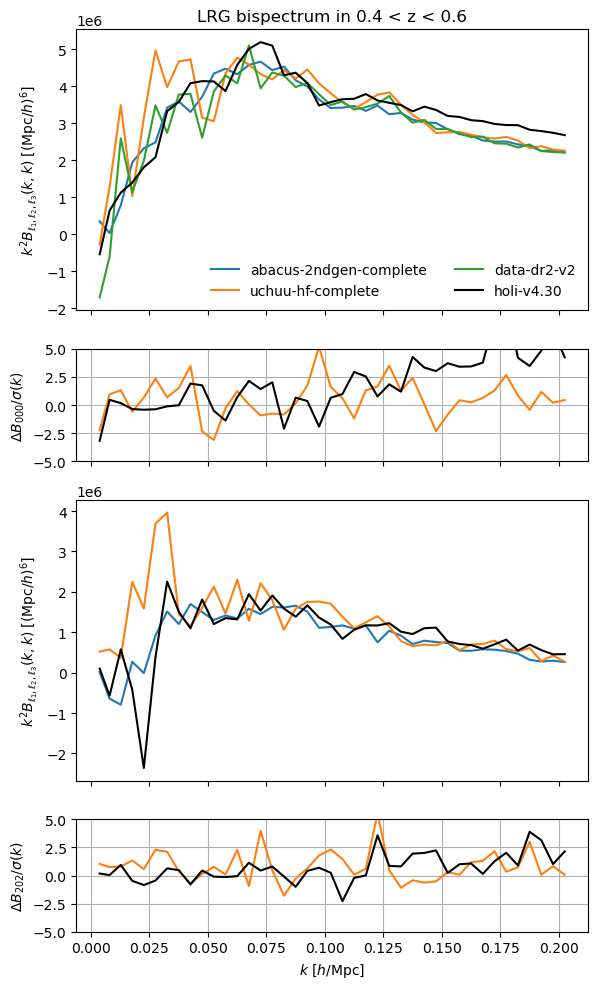

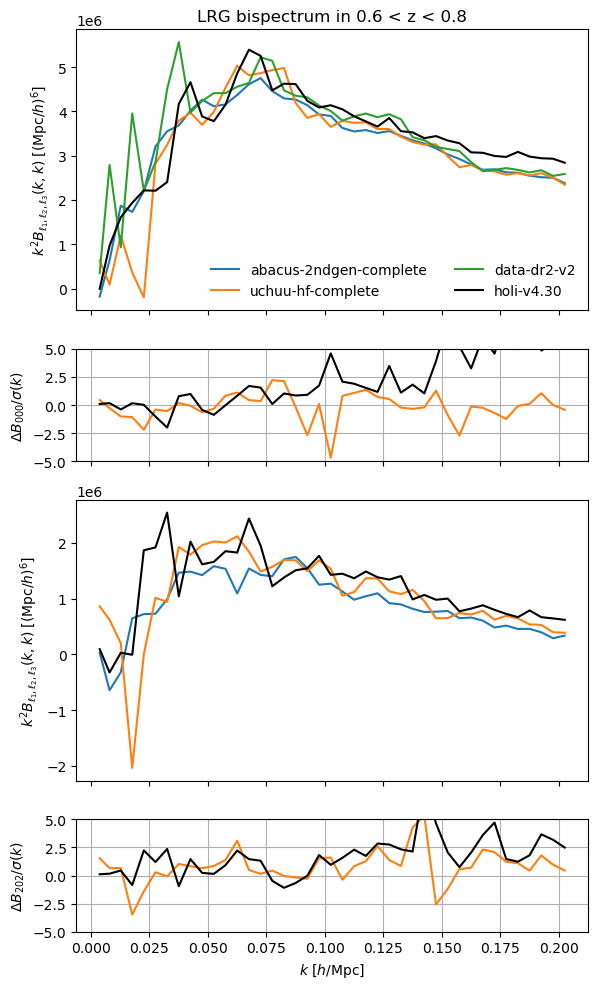

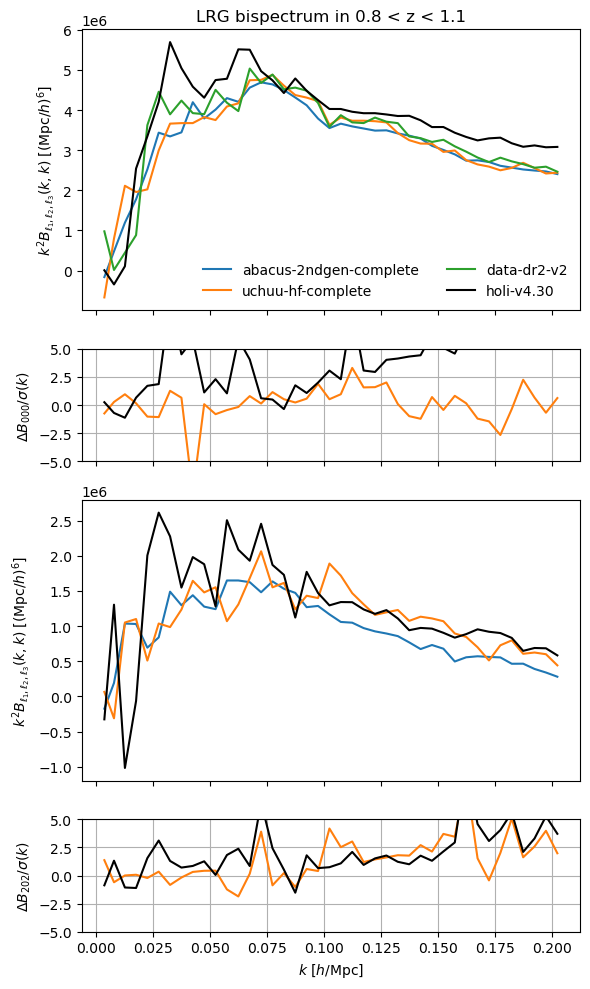

In [2]:
region = 'NGC'
tracers = [('LRG', (0.4, 0.6)), ('LRG', (0.6, 0.8)), ('LRG', (0.8, 1.1))]
versions = {'abacus-2ndgen-complete': {'version': 'abacus-2ndgen-complete', 'weight': 'default', 'cut': False, 'auw': False},
            'uchuu-hf-complete': {'version': 'uchuu-hf-complete', 'weight': 'default', 'cut': False, 'auw': False},
            'data-dr2-v2': {'version': 'data-dr2-v2', 'weight': 'default', 'cut': False, 'auw': True},
            'holi-v4.30': {'version': 'holi-v4.30', 'weight': 'default', 'cut': False, 'auw': False}}

colors = dict(zip(versions, ['C0', 'C1', 'C2', 'k']))
linestyles = dict(zip(versions, ['-'] * len(colors)))
version_ref = 'abacus-2ndgen-complete'

for tracer, zrange in tracers:
    #plot_stats('mesh2_spectrum', versions, tracer, zrange, region)
    plot_stats('mesh3_spectrum_sugiyama-diagonal', versions, tracer, zrange, region)